<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Downtown_LA_Traffic_Prediction_I110_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras

In [ ]:
controller_data = pd.read_csv('Combined flows.csv')
controller_data.dropna(how='all', inplace=True)

In [ ]:
controller_data["5 Minutes"] = pd.to_datetime(controller_data["5 Minutes"])
controller_data.set_index("5 Minutes", inplace=True)

# Keep only the relevant column
time_flow = controller_data[['Mainline VDS 760650 - AMADOR Flow (Veh/5 Minutes)', 'Mainline VDS 718045 - STADUIM Flow (Veh/5 Minutes)', 'Mainline VDS 775610 - SUNSET Flow (Veh/5 Minutes)', 'Mainline VDS 718173 - THIRD Flow (Veh/5 Minutes)', 'Mainline VDS 760643 - 8TH Flow (Veh/5 Minutes)', 'Mainline VDS 774671 - 14TH STREET Flow (Veh/5 Minutes)', 'Mainline VDS 760635 - 11TH Flow (Veh/5 Minutes)', 'Mainline VDS 718166 - WASHINGTON2 Flow (Veh/5 Minutes)', 'Mainline VDS 775636 - 21ST STREET Flow (Veh/5 Minutes)', 'Mainline VDS 764037 - ADAMS Flow (Veh/5 Minutes)', 'Mainline VDS 763447 - EXPOSITION2 Flow (Veh/5 Minutes)', 'Mainline VDS 763246 - EXPOSITION1 Flow (Veh/5 Minutes)', 'Mainline VDS 718041 - KING BLVD Flow (Veh/5 Minutes)']]

print(time_flow)

                     Mainline VDS 760650 - AMADOR Flow (Veh/5 Minutes)  \
5 Minutes                                                                
2024-04-01 00:00:00                                              210.0   
2024-04-01 00:05:00                                              204.0   
2024-04-01 00:10:00                                              198.0   
2024-04-01 00:15:00                                              192.0   
2024-04-01 00:20:00                                              185.0   
...                                                                ...   
2024-04-07 23:35:00                                              268.0   
2024-04-07 23:40:00                                              264.0   
2024-04-07 23:45:00                                              249.0   
2024-04-07 23:50:00                                              239.0   
2024-04-07 23:55:00                                              229.0   

                     Mainline VDS 718

In [ ]:
print(time_flow.shape)

(2016, 13)


In [ ]:
# Normalise
scaler = MinMaxScaler()
flow_normalised = scaler.fit_transform(time_flow)

In [ ]:
# Train and validation split
train = len(flow_normalised)*0.8
X_train, X_val, = flow_normalised[:int(train), :], flow_normalised[int(train):, :]

In [ ]:
print(X_train.shape)

(1612, 13)


In [ ]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 12
X_train, y_train = create_dataset(X_train, look_back)
X_val, y_val = create_dataset(X_val, look_back)


# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

In [ ]:
print(X_train.shape)

(1600, 12, 13)


In [ ]:
from keras import layers

input_layer = keras.layers.Input(shape=(look_back, 13))
encoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = keras.layers.RepeatVector(look_back)(encoded)
decoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = keras.layers.TimeDistributed(layers.Dense(1, activation='linear'))(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 12, 13)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 12, 64)              │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 12, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 12, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 12, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,281 (223.75 KB)

 Trainable params: 57,281 (223.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_val, X_val])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.2281 - val_loss: 0.0275
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0187 - val_loss: 0.0032
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

In [ ]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_val)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(1, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_val, y_val))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5381 - val_loss: nan
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - val_loss: nan
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: nan
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: nan
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: nan
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: nan
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: nan
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: nan
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: nan
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: nan
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: nan
Epoch 12/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: nan
Epoch 13/20
51/51 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


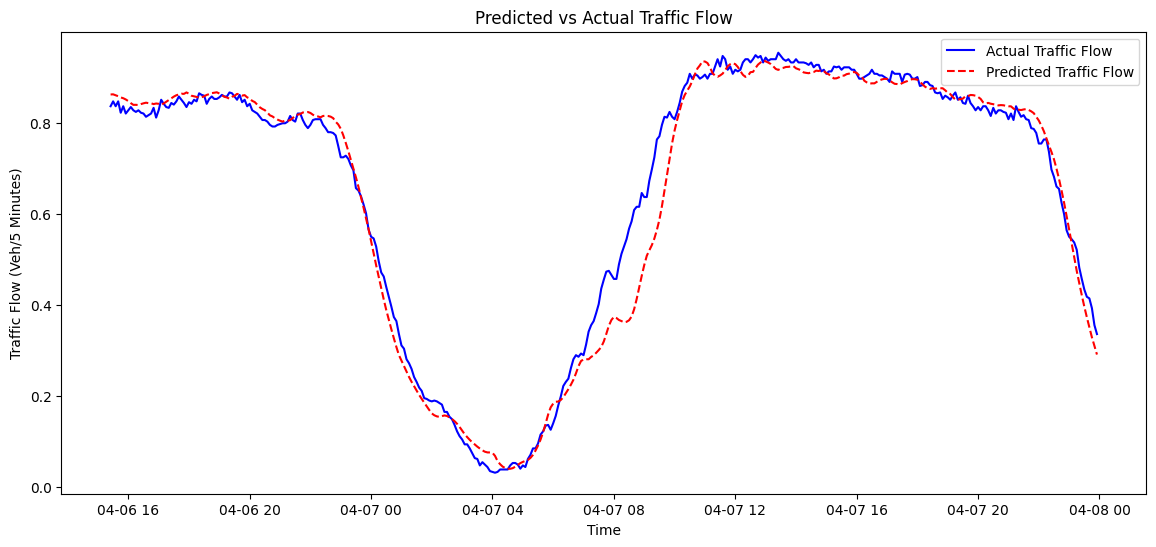

In [ ]:
# timestamps from validation set.
timestamps = time_flow.index[-len(y_val):]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_val[:, -1], label='Actual Traffic Flow', color='blue')
plt.plot(timestamps, y_pred, label='Predicted Traffic Flow', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Traffic Flow (Veh/5 Minutes)')
plt.title('Predicted vs Actual Traffic Flow')
plt.legend()
plt.show()


In [ ]:
from folium.plugins import HeatMapWithTime
import folium
import pandas as pd
import numpy as np
import branca.colormap as cm

# Sample time_flow DataFrame
# Ensure that your actual DataFrame has a timestamp index and valid flow data
time_flow = pd.DataFrame({
    "AMADOR": time_flow['Mainline VDS 760650 - AMADOR Flow (Veh/5 Minutes)'].tolist(),
    "STADIUM": time_flow['Mainline VDS 718045 - STADUIM Flow (Veh/5 Minutes)'].tolist(),
    "SUNSET": time_flow['Mainline VDS 775610 - SUNSET Flow (Veh/5 Minutes)'].tolist(),
    "THIRD": time_flow['Mainline VDS 718173 - THIRD Flow (Veh/5 Minutes)'].tolist(),
    "8TH": time_flow['Mainline VDS 760643 - 8TH Flow (Veh/5 Minutes)'].tolist(),
    "14TH": time_flow['Mainline VDS 774671 - 14TH STREET Flow (Veh/5 Minutes)'].tolist(),
    "11TH": time_flow['Mainline VDS 760635 - 11TH Flow (Veh/5 Minutes)'].tolist(),
    "WASHINGTON2": time_flow['Mainline VDS 718166 - WASHINGTON2 Flow (Veh/5 Minutes)'].tolist(),
    "21ST_STREET": time_flow['Mainline VDS 775636 - 21ST STREET Flow (Veh/5 Minutes)'].tolist(),
    "ADAMS": time_flow['Mainline VDS 764037 - ADAMS Flow (Veh/5 Minutes)'].tolist(),
    "EXPOSITION2": time_flow['Mainline VDS 763447 - EXPOSITION2 Flow (Veh/5 Minutes)'].tolist(),
    "EXPOSITION1": time_flow['Mainline VDS 763246 - EXPOSITION1 Flow (Veh/5 Minutes)'].tolist(),
    "KING_BLVD": time_flow['Mainline VDS 718041 - KING BLVD Flow (Veh/5 Minutes)'].tolist()
}, index=pd.date_range("2024-04-01", periods=2016, freq="5T"))

detector_locations = {
    "AMADOR": (34.074472, -118.233103),
    "STADUIM": (34.068002, -118.238015),
    "SUNSET": (34.063457, -118.247963),
    "THIRD": (34.055433, -118.256754),
    "8TH": (34.04828, -118.266145),
    "14TH": (34.042012, -118.273319),
    "11TH": (34.040612, -118.27373),
    "WASHINGTON2": (34.03711, -118.274257),
    "21ST_STREET": (34.031839, -118.274646),
    "ADAMS": (34.026164, -118.275402),
    "EXPOSITION2": (34.018314, -118.280127),
    "EXPOSITION1": (34.015503, -118.281106),
    "KING_BLVD": (34.009215, -118.281288)
}

# Normalize flow values
max_flow = time_flow.max().max()
time_flow = time_flow / max_flow  # Scale between 0-1

# Prepare Heatmap Data
heatmap_data = []
for timestamp, row in time_flow.iterrows():
    time_slot = []
    for column, flow_value in row.items():
        detector_id = column.split()[0]
        if detector_id in detector_locations:
            lat, lon = detector_locations[detector_id]
            time_slot.append([lat, lon, flow_value])
    heatmap_data.append(time_slot)

# Flatten the data
flattened_data = []
for timestamp, time_slot in zip(time_flow.index, heatmap_data):
    for lat, lon, weight in time_slot:
        flattened_data.append([timestamp, lat, lon, weight])

# Create DataFrame
df_heatmap = pd.DataFrame(flattened_data, columns=["Timestamp", "Latitude", "Longitude", "Weight"])

# Convert Timestamp to datetime and sort
df_heatmap['Timestamp'] = pd.to_datetime(df_heatmap['Timestamp'])
df_heatmap = df_heatmap.sort_values(by="Timestamp")

# Prepare data for HeatMapWithTime
time_index = list(df_heatmap['Timestamp'].astype(str).unique())

data = []
for _, d in df_heatmap.groupby('Timestamp'):
    data.append([[row['Latitude'], row['Longitude'], row['Weight']] for _, row in d.iterrows()])

hmt = folium.Map(location=[34.040612,	-118.27373],
                tiles="cartodbpositron",
                zoom_start=13,
                control_scale=True,
                max_zoom=12,
                min_zoom=13
                 )

HeatMapWithTime(data,
                index=time_index,
                auto_play=True,
                max_opacity=0.8,
                radius=15,
                use_local_extrema=False
               ).add_to(hmt)

hmt


<ipython-input-116-e064b2273804>:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  }, index=pd.date_range("2024-04-01", periods=2016, freq="5T"))
